# Chapter6 학습 관련 기술들

6.1 매개변수 갱신
신경망 학습의 목적: 손실 함수의 값을 가능한 한 낮추는 매개변수를 찾는 것  ->  최적화(optimization)이라 한다.  
확률적 경사 하강법(SGD): 매개변수의 기울기를 구해, 기울어진 방향으로 매개변술 값을 갱신하는 일을 몇 번이고 반복해서 점점 최적의 값에 다가가는 것

In [2]:
import numpy as np
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr
        
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

SGD  
장점: 단순하고 구현이 쉽다.  
단점: 1) 비등방성 함수(방향에 따라 성질(기울기)가 달라지는 함수)에서는 탐색 경로가 비효율적이다.

-> 모멘텀, AdaGrad, Adam 이라는 세 방법 등장

6.1.4 모멘텀  
모멘텀(Momentum): '운동량'을 뜻하는 단어

In [3]:
class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None
        
    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
        
        for key in params.keys():
            self.v[key] = self.momentum*self.v[key] - self.lr*grads[key]
            params[key] += self.v[key]
            

6.1.5 AdaGrad
신경망 학습에서 학습률이 너무 작으면 시간이 너무 길어지고, 반대로 너무 크면 발산하여 학습이 제대로 되지 않음  
학습률 감소(learning decay): 학습을 진행하면서 학습률을 점차 줄여가는 방법으로, 학습률을 정하는 효과적 기술  
가장 간단한 방법은 매개변수 '전체'의 학습률 값을 일괄적으로 낮추는 것
->(발전)-> AdaGrad  

AdaGrad: '각각의' 매개변수에 '맞춤형' 값으로 만드는 것  

In [4]:
class AdaGrad:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
        
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
            
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

6.1.6 Adam
모멘텀과 AdaGrad의 융합  
하이퍼파라미터의 '편향 보정'이 진행된다.  

Adam은 하이퍼파라미터를 3개 설정한다. 학습률, 일차 모멘텀용 계수, 이차 모멘텀용 계수  
기본 설정값은 일차 모멘텀용 계수는 0.9, 이차 모멘텀용 계수는 0.999 -> 기본 설정값으로 하면 많은 경우에 좋은 결과를 얻을 수 있다.

6.2 가중치의 초깃값  
신경망 학습에서 특히 중요한 것이 가중치의 초깃값  

6.2.1 초깃값을 0으로 하면?  
가중치 감소(weight decay): 오버피팅을 억제해 범용 성능을 높이는 테크닉으로, 가중치 매개변수의 값이 작아지도록 학습하는 방법  

초깃값을 0으로 하면 안되는 이유(가중치를 균일한 값으로 설정): 오차 역번파법에서 모든 가중치의 값이 똑같이 갱신되기 때문  
-> 가중치를 여러 개 갖는 의미를 사라지게 함 -> 초깃값을 무작위로 설정해야 한다.  

6.2.2 은닉층의 활성화값 분포  
은닉층의 활성화값(활성화 함수의 출력 데이터)의 분포를 관찰하면 중요한 정보를 얻을 수 있다.

In [5]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

x = np.random.randn(1000, 100) # 1000개의 데이터
node_num = 100                 # 각 은닉층의 노드(뉴런) 수
hidden_layer_size = 5          # 은닉층이 5개
activations = {}               # 이곳에 활성화 결과(활성화 값) 저장

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
        
    w = np.random.randn(node_num, node_num) * 1
    a = np.dot(x, w)
    z = sigmoid(a)
    activations[i] = z

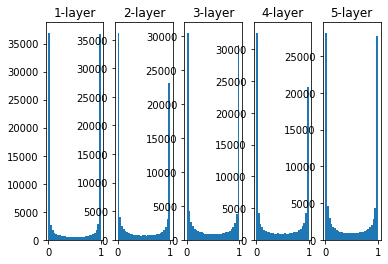

In [6]:
# 히스토그램 그리기
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

이 코드에서는 표준편차가 1인 정규분포 이용  
사용한 시그모이드 함수는 출력이 0에 가까워지거나 1에 가까워지면 미분은 0에 다가간다.  
그래서 데이터가 0과 1에 치우쳐 분포하게 되면 역전파의 기울기 값이 점점 작아지다가 사라진다. -> 기울기 소실(gradient vanishing) 문제  
층을 깊게 하는 딥러닝에서는 기울기 소실은 심각한 문제가 될 수 있다.

In [7]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

x = np.random.randn(1000, 100) # 1000개의 데이터
node_num = 100                 # 각 은닉층의 노드(뉴런) 수
hidden_layer_size = 5          # 은닉층이 5개
activations = {}               # 이곳에 활성화 결과(활성화 값) 저장

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
        
    w = np.random.randn(node_num, node_num) * 0.01
    a = np.dot(x, w)
    z = sigmoid(a)
    activations[i] = z

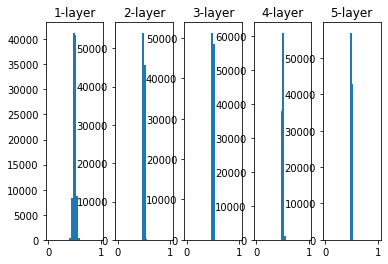

In [8]:
# 히스토그램 그리기
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

이 코드에서는 표준편차 0.01로 설정  
앞의 코드처럼 0과 1로 치우치진 않아서 기울기 소실 문제는 일어나지 않는다.  
하지만 활성화 값들이 치우쳤다는것은 표현력 관점에서 큰 문제가 있다. -> 다수의 뉴런이 거의 같은 값을 출력하고 있다. -> 뉴런을 여러 개 둔 이유가 없다.  
즉, 활상화값들이 치우치면 표현력을 제한한다는 관점에서 문제가 된다.

각 층의 활성화 값은 고루 분포되어야 한다. -> 적당하게 다양한 데이터가 흐르게 해야 신경망 학습이 효율적으로 이루어짐

Xavier 초깃값  
현재 Xavier 초깃값은 일반적인 딥러닝 프레임워크들이 표준적으로 이용한다.  

In [9]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

x = np.random.randn(1000, 100) # 1000개의 데이터
node_num = 100                 # 각 은닉층의 노드(뉴런) 수
hidden_layer_size = 5          # 은닉층이 5개
activations = {}               # 이곳에 활성화 결과(활성화 값) 저장

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]
        
    w = np.random.randn(node_num, node_num) / np.sqrt(node_num)
    a = np.dot(x, w)
    z = sigmoid(a)
    activations[i] = z

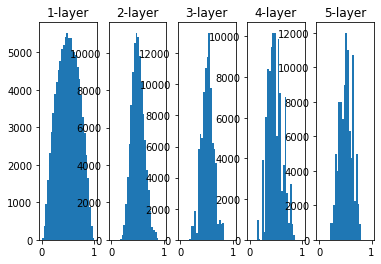

In [10]:
# 히스토그램 그리기
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()

층이 깊어지면서 형태가 다소 일그러지지만, 앞에서 본 방식보다 확실히 넓게 분포됨을 알 수 있다.  
각 층에 흐르는 데이터가 적당히 퍼져 있으므로, 시그모이드 함수의 표현력도 제한받지 않고 학습이 효율적으로 이뤄짖ㄹ 것으로 기대  

위 그래프에서 오른쪽으로 갈수록 약간씩 일그러지고 있다. 시그모이드 함수를 tanh 함수를 이용하면 개선된다.  
활성화 함수용으로는 원점에서 대칭인 함수가 바람직하고 알려져 있음

6.2.3 ReLU를 사용할 때의 가중치 초깃값  
ReLU를 이용할 때 카이밍 히(Kaiming He)의 이름을 딴 He 초깃값을 사용한다.  
ReLU는 음의 영역이 0이라서 더 넓게 분포시키기 위해 2배의 계수가 필요하다고 직감적으로 해석할 수 있다.(Xavier 초깃값의 두 배)  

신경망에 아주 작은 데이터가 흐른다는 것은 역전파 때 가중치의 기울기 역시 작아짐을 뜻한다. -> 실제로도 학습이 거의 이뤄지지 않을 것이다.  
활성화 함수로 ReLU를 사용한 경우에 Xavier 초깃값 결과를 보면 활성화 값들의 치우침도 커지고, 학습할 때 '기울기 소실' 문제를 일으킨다.  

He 초깃값은 모든 층에서 균일하게 분포한다. 층이 깊어져도 분포가 균일하게 유지되어 역전파 때도 적절한 값이 나올 것으로 기대 가능  

ReLU를 사용할 때는 He 초깃값을, sigmoid나 tanh 등의 S자 모양 곡선일 때는 Xavier 초깃값을 사용한다.

6.3 배치 정규화  
각 층이 활성화를 적당히 퍼뜨리도록 '강제'해보면 어떨까? -> 배치 정규화(Batch Normalization)의 등장  

6.3.1 배치 정규화 알고리즘  
배치 정규화는 2015년에 제안된 방법이다. 나온 지 얼마 안 된 기법이지만 많이 쓰인다.  

배치 정규화 장점
1) 학습을 빨리 진행할 수 있다.(학습속도 개선)  
2) 초깃값에 크게 의존하지 않는다.
3) 오버피팅 억제(드롭아웃 등의 필요성 억제)  

방법
데이터 분포를 정규화하는 '배치 정규화(Batch Norm) 계층'을 신경망에 삽입  
데이터 분포가 평균이 0, 분산이 1이 되도록 정규화한다. -> 수식은 책 참고  
활성화 함수의 앞 또는 뒤에 삽입함으로써 데이터 분포가 덜 치우치게 할 수 있다.  

배치 정규화 계층마다 이 정규화된 데이터에 고유한 확대(scale), 이동(shift) 변환을 수행한다.

6.4 바른 학습을 위해  
오버피팅: 신경망이 훈련 데이터에만 지나치게 적응되어 그 외의 데이터에는 제대로 대응하지 못하는 상태  

6.4.1 오버피팅  
발생 상황  
1) 매개변수가 많고 표현력이 높은 모델  
2) 훈련 데이터가 적음  

In [20]:
# coding: utf-8
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from multi_layer_net import MultiLayerNet
from optimizer import SGD

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)
# 오버피팅을 재현하기 위해 학습 데이터 수를 줄임
x_train = x_train[:300]
t_train = t_train[:300]

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10)
optimizer = SGD(lr=0.01) # 학습률이 0.01인 SGD로 매개변수 갱신
max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)
    
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        
        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break

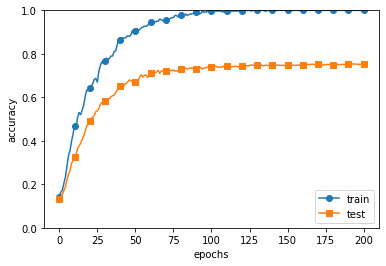

In [21]:
# 그래프 그리기==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

6.4.2 가중치 감소  
오버피팅 억제용으로 예로부터 많이 이용해온 방법 중 가중치 감소(weight decay)라는 것이 있다.
가중치 감소는 학습 과정에서 큰 가중치에 대해 그에 상응하는 큰 패널티를 부과하여 오버피팅을 억제하는 방법이다.  
원래 오버피팅은 가중치 매개변수의 값이 커서 발생하는 경우가 많기 때문  

신경망 학습의 목적은 손실 함수의 값을 줄이는 것  
가중치의 제곱 노름을 손실 함수에 더하면 가중치가 커지느 것을 억제할 수 있다.
람다는 정규화의 세기를 조절하는 하이퍼파라미터  

책 참고하기

6.4.3 드롭아웃  
가중치 감소는 복잡한 신경망 모델에서는 대응하기 어려워진다. -> 드롭아웃(Dropout) 기법 사용  

드롭아웃: 뉴런을 임의로 삭제하면서 학습하는 방법  

훈련 때 은닉층의 뉴런을 무작위로 골라 삭제한다.  

In [22]:
class Dropout:
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None
        
    def forward(self, x, train_flg=True):
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
        else:
            return x * (1.0 - self.dropout_ratio)
        
    def backward(self, dout):
        return dout * self.mask

6.5 적절한 하이퍼파라미터 값 찾기  
하이퍼파라미터의 예
: 각 층의 뉴런 수, 배치 크기, 매개변수 갱신 시의 학습률, 가중치 감소 등  

6.5.1 검증 데이터  
하이퍼파라미터의 성능을 평가할 때, 시험 데이터를 사용하면 안 되는 이유: 하이퍼파라미터 값이 시험 데이터에 오버피팅 됨  
시험 데이터에만 적합하도록 조정되어 버린다.  

검증데이터(validation data): 하이퍼파라미터 조정용 데이터  

훈련 데이터는 매개변수(가중치, 편향)의 학습에 이용  
검증 데이터는 하이퍼파라미터의 성능을 평가하는 데 이용  
시험 데이터는 범용 성능을 확인하기 위해서 마지막에(이상적으로 한 번) 이용  

In [35]:
(x_train, t_train), (x_test, t_test) = load_mnist()

# 훈련 데이터를 뒤섞는다.
x_train, t_train = shuffle_dataset(x_train, t_train)

# 20%를 검증 데이터로 분할
validation_rate = 0.20
validation_num = int(x_train.shape[0] * validation_rate)

x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]

6.5.2 하이퍼파라미터 최적화  
하이퍼팔라미터를 최적화할 때 핵심은 하이퍼파라미터의 '최적 값'이 존재한느 범위를 조금씩 줄여간다는 것  
우선 대략적인 범위를 설정한다. 그 범위에서 무작위로 하이퍼파라미터 값을 골라낸(샘플링) 후, 그 값으로 정확도를 평가한다.  
정확도를 잘 살피면서 이 작업을 여러 번 반복하며 하이퍼파라미터의 '최적 값'의 범위를 좁혀가는 것  

그리드 서치(gird search)같은 규칙적인 탐색 보다 무작위로 샘플링해 탐색하는 편이 좋은 결과를 낸다고 알려져 있다.  
-> 최종 정확도에 미치는 영향력이 하이퍼파라미터마다 다르기 때문  

하이퍼파라미터의 범위는 대력적으로 정한다. 0.001에서 1000 사이와 같이 '10의 거듭제곱' 단위로 범위를 지정(로그 스케일(log scale))로 지정한다.  
학습을 위한 에폭을 작게 하여, 1회 평가에 걸리는 시간을 단축하는 것이 효과적  

0단계: 하이퍼파라미터 값의 범위를 설정  
1단계: 설정된 범위에서 하이퍼파라미터의 값을 무작위로 추출  
2단계: 1단계에서 샘플링한 하이퍼파라미터 값을 사용하여 학습하고, 검증 데이터로 정확도를 평가한다.(단, 에폭은 작게 설정)  
3단계: 1단계와 2단계를 특정 횟수(100회 등) 반복하여, 그 정확도의 결과를 보고 하이퍼파라미터의 범위를 좁힌다.  

위의 방법은 수행자의 능력(지혜, 직감)에 달린 방법이다.  

베이즈 최적화(Bayesian optimization): 베이즈 정리를 중심으로 한 수학 이론을 구사하여 더 엄밀하고 효율적으로 최적화를 수행  

6.5.3 하이퍼파라미터 최적화 구현하기

In [36]:
weight_decay = 10 ** np.random.uniform(-8, -4)
lr = 10 ** np.random.uniform(-6, -2)

In [38]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from multi_layer_net import MultiLayerNet
from util import shuffle_dataset
from trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 결과를 빠르게 얻기 위해 훈련 데이터를 줄임
x_train = x_train[:500]
t_train = t_train[:500]

# 20%를 검증 데이터로 분할
validation_rate = 0.20
validation_num = int(x_train.shape[0] * validation_rate)
x_train, t_train = shuffle_dataset(x_train, t_train)
x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]


def __train(lr, weight_decay, epocs=50):
    network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                            output_size=10, weight_decay_lambda=weight_decay)
    trainer = Trainer(network, x_train, t_train, x_val, t_val,
                      epochs=epocs, mini_batch_size=100,
                      optimizer='sgd', optimizer_param={'lr': lr}, verbose=False)
    trainer.train()

    return trainer.test_acc_list, trainer.train_acc_list


# 하이퍼파라미터 무작위 탐색======================================
optimization_trial = 100
results_val = {}
results_train = {}
for _ in range(optimization_trial):
    # 탐색한 하이퍼파라미터의 범위 지정===============
    weight_decay = 10 ** np.random.uniform(-8, -4)
    lr = 10 ** np.random.uniform(-6, -2)
    # ================================================

    val_acc_list, train_acc_list = __train(lr, weight_decay)
    print("val acc:" + str(val_acc_list[-1]) + " | lr:" + str(lr) + ", weight decay:" + str(weight_decay))
    key = "lr:" + str(lr) + ", weight decay:" + str(weight_decay)
    results_val[key] = val_acc_list
    results_train[key] = train_acc_list

# 그래프 그리기========================================================
print("=========== Hyper-Parameter Optimization Result ===========")
graph_draw_num = 20
col_num = 5
row_num = int(np.ceil(graph_draw_num / col_num))
i = 0

for key, val_acc_list in sorted(results_val.items(), key=lambda x:x[1][-1], reverse=True):
    print("Best-" + str(i+1) + "(val acc:" + str(val_acc_list[-1]) + ") | " + key)

    plt.subplot(row_num, col_num, i+1)
    plt.title("Best-" + str(i+1))
    plt.ylim(0.0, 1.0)
    if i % 5: plt.yticks([])
    plt.xticks([])
    x = np.arange(len(val_acc_list))
    plt.plot(x, val_acc_list)
    plt.plot(x, results_train[key], "--")
    i += 1

    if i >= graph_draw_num:
        break

plt.show()

val acc:0.66 | lr:0.005182768315229939, weight decay:6.429614202168335e-05
val acc:0.46 | lr:0.003292709544670393, weight decay:3.576487258239015e-08
val acc:0.12 | lr:1.1658033117269681e-06, weight decay:8.164139444206026e-08
val acc:0.15 | lr:6.928921643792929e-05, weight decay:2.5801411879061926e-05
val acc:0.12 | lr:7.266893221020888e-05, weight decay:8.043263339528219e-08
val acc:0.09 | lr:1.0836697439802841e-05, weight decay:5.177264668958164e-05
val acc:0.13 | lr:2.9466346906407e-06, weight decay:7.588126906888886e-07
val acc:0.15 | lr:1.1957079149323249e-05, weight decay:1.1107549486173742e-06
val acc:0.17 | lr:6.140432908914127e-05, weight decay:4.55749648738953e-08
val acc:0.13 | lr:0.0002421053707982847, weight decay:2.7436036611704352e-06
val acc:0.1 | lr:2.933467078177381e-06, weight decay:2.178458745329974e-06
val acc:0.16 | lr:2.040062301392429e-06, weight decay:8.638798052370729e-08
val acc:0.09 | lr:2.0686711581637386e-05, weight decay:4.0767551173328535e-08
val acc:0.

KeyboardInterrupt: 

6.6 정리  
* 매개변수 갱신 방법에는 확률적 경사 하강법(SGD) 외에도 모멘텀, AdaGrad, Adam 등이 있다.  
* 가중치 초깃값을 정하는 방법은 올바른 학습을 하는 데 매우 중요하다.  
* 가중치의 초깃값으로는 Xavier 초깃값, He 초깃값이 효과적이다.  
* 배치 정규화를 이용하면 학습을 빠르게 진행할 수 있으며, 초깃값에 영향을 덜 받게 된다.  
* 오버피팅을 억제하는 정규화 기술로는 가중치 감소, 드롭아웃이 있다.  
* 하이퍼파라미터 값 탐색은 최적 값이 존재할 법한 범위를 점차 좁히면서 하는 것이 효과적이다.